In [6]:
# Set all dependency and variable

# %load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.python.client import device_lib 
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import numpy as np

import sklearn.metrics

from skimage import exposure
from skimage import filters

import seaborn as sn
import pandas as pd

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5728091500041107005
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9674385258919748964
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1391427175
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16136844649646799286
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1407167535628151970
physical_device_desc: "device: XLA_GPU device"
]


In [7]:
# Check number of CPU and GPU that Tensorflow used\

print("Num CPUUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num CPUUs Available:  1
Num GPUs Available:  1


In [11]:
IMAGE_SIZE = 224
BATCH_SIZE = 24

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [9]:
# Make preprocessing function if needed

def preprocess(image):
  image = filters.median(image)
  p2, p98 = np.percentile(image, (2, 98))
  image = exposure.rescale_intensity(image, in_range=(p2, p98))
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = exposure.equalize_adapthist(image, clip_limit=0.03)
  image = filters.gaussian(image, sigma=1)
  
  image = image[None, ...]
  return image

In [12]:
TRAINING_DIR = "dataset"
VALIDATION_DIR = "dataset_kue"
datagen = ImageDataGenerator(
#     rescale = 1./127.5,
    rescale = 1./255. ,
    # rotation_range=40,
    # featurewise_center=True,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.4,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    preprocessing_function = preprocess,
    validation_split=0.1,
      )

print("Loading training data...\t\t", end='')
train_generator = datagen.flow_from_directory(
	  TRAINING_DIR,
  	target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',

)

print("Loading validation data...\t\t", end='')
validation_generator = datagen.flow_from_directory(
  	TRAINING_DIR,
#     VALIDATION_DIR,
	  target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
)



Loading training data...		Found 752 images belonging to 8 classes.
Loading validation data...		Found 79 images belonging to 8 classes.


In [13]:
TEST_DIR = "dataset_kue_test_2"

test_generator = ImageDataGenerator(
    rescale = 1./255. ,
#     rescale = 1./127.5 ,
)
print("Loading testing data...\t\t", end='')
test_data = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

# image = tf.keras.preprocessing.image.load_img(TEST_DIR)
# test_arr = keras.preprocessing.image.img_to_array(image)
# test_arr = np.array([input_arr])

Loading testing data...		Found 53 images belonging to 8 classes.


In [14]:
class_names = []
for a in train_generator.class_indices:
    class_names.append(a)
print(class_names)

['kue_cenil', 'kue_clorot', 'kue_dadar_gulung', 'kue_klepon', 'kue_lapis', 'kue_lumpur', 'kue_mendut', 'kue_serabi']


In [15]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

<ipython-input-9-449cb9175452>:11: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  image = filters.gaussian(image, sigma=1)


((24, 224, 224, 3), (24, 8))

In [16]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'kue_cenil': 0, 'kue_clorot': 1, 'kue_dadar_gulung': 2, 'kue_klepon': 3, 'kue_lapis': 4, 'kue_lumpur': 5, 'kue_mendut': 6, 'kue_serabi': 7}


In [17]:
base_model = tf.keras.applications.MobileNetV2(
    IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False
# base_model.summary()

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


prediction_layer = tf.keras.layers.Dense(128, activation='relu')
prediction_layer2 = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')


In [20]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
# x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)
outputs = prediction_layer2(x)
model = tf.keras.Model(inputs, outputs)

l_rate = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=l_rate), metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                

In [21]:
# Train the data

# %tensorboard --logdir logs
n_epoch = 10
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# history = data_prep.fit(train_generator,
#                     steps_per_epoch=len(train_generator), 
# #                     steps_per_epoch=100, 
#                     epochs=10, 
#                     validation_data = validation_generator, 
#                     validation_steps=len(validation_generator),
# #                     validation_steps=100,
# #                     batch_size=32,
#                     # verbose=1,
#                     # callbacks=[es_callback],
# #                     callbacks=[cm_callback],
#                     )

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=n_epoch, 
                    validation_data = validation_generator, 
                    validation_steps=len(validation_generator),
                    # verbose=1,
                    # callbacks=[es_callback],
#                     callbacks=[cm_callback],
                    )

<ipython-input-9-449cb9175452>:11: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  image = filters.gaussian(image, sigma=1)


Epoch 1/10
32/32 [==============================] - 87s 3s/step - loss: 2.1967 - accuracy: 0.1356 - val_loss: 2.0636 - val_accuracy: 0.1646
Epoch 2/10
32/32 [==============================] - 72s 2s/step - loss: 2.1360 - accuracy: 0.1370 - val_loss: 2.0625 - val_accuracy: 0.1646
Epoch 3/10
32/32 [==============================] - 77s 2s/step - loss: 2.1146 - accuracy: 0.1423 - val_loss: 2.0587 - val_accuracy: 0.1392
Epoch 4/10
32/32 [==============================] - 77s 2s/step - loss: 2.1261 - accuracy: 0.1250 - val_loss: 2.0627 - val_accuracy: 0.1646
Epoch 5/10
32/32 [==============================] - 71s 2s/step - loss: 2.1293 - accuracy: 0.1449 - val_loss: 2.0659 - val_accuracy: 0.1139
Epoch 6/10
32/32 [==============================] - 72s 2s/step - loss: 2.1050 - accuracy: 0.1396 - val_loss: 2.0602 - val_accuracy: 0.1646
Epoch 7/10
32/32 [==============================] - 71s 2s/step - loss: 2.0870 - accuracy: 0.1489 - val_loss: 2.0578 - val_accuracy: 0.1646
Epoch 8/10
32/32 [==

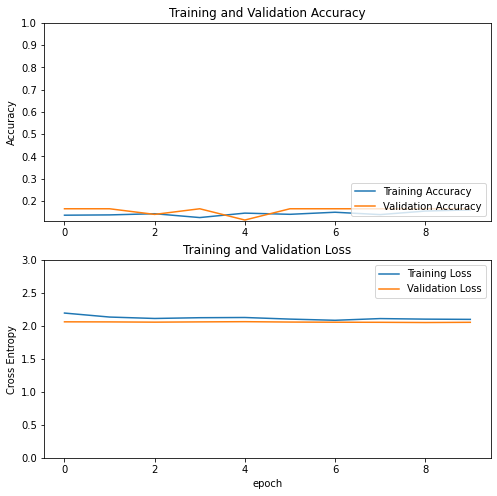

In [22]:
# Graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [23]:
print("Model evaluate:")
results = model.evaluate(test_data)

Model evaluate:
3/3 [==============================] - 1s 241ms/step - loss: 2.2063 - accuracy: 0.2075


Confusion Matrix
[[1 0 0 6 1 0 0 0]
 [0 0 0 4 0 0 1 0]
 [0 2 0 4 0 0 0 0]
 [1 0 0 4 0 0 1 0]
 [1 0 0 3 0 0 0 2]
 [1 1 0 4 0 0 0 0]
 [1 1 0 3 1 0 1 1]
 [0 1 0 7 0 0 0 0]]


<AxesSubplot:>

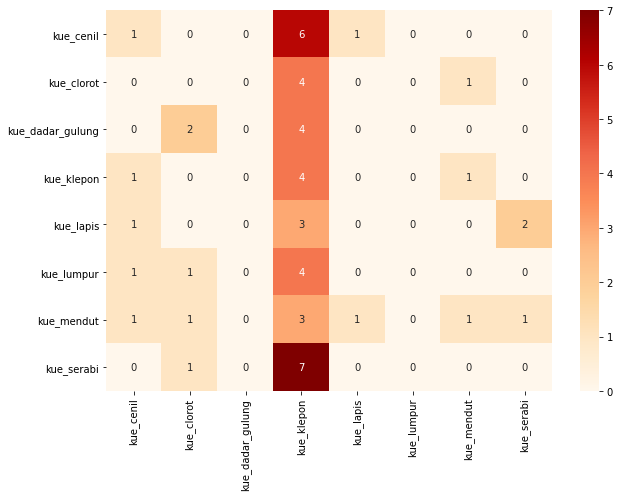

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data,  BATCH_SIZE // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[1 0 1 1 2 1 1 1]
 [0 2 0 0 1 1 1 0]
 [1 0 0 2 1 0 1 1]
 [1 0 1 1 0 1 2 0]
 [1 0 1 0 1 0 1 2]
 [1 0 2 0 0 1 1 1]
 [0 0 2 2 1 1 0 2]
 [0 2 0 1 0 1 2 2]]


<AxesSubplot:>

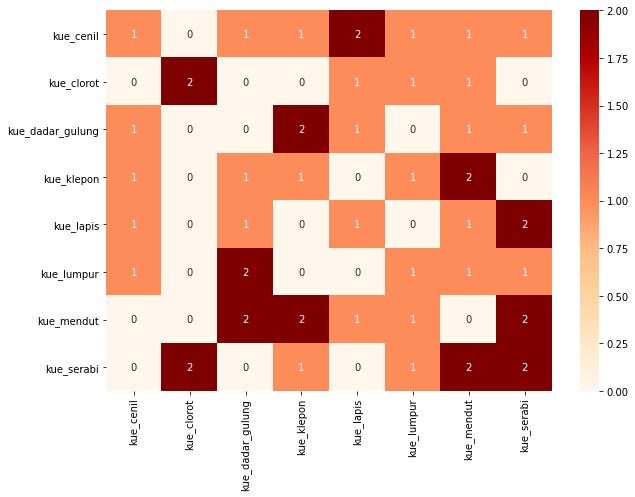

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data,  BATCH_SIZE // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[0 0 3 1 2 1 0 1]
 [3 0 0 0 0 1 1 0]
 [0 0 1 0 3 0 0 2]
 [0 0 0 3 0 0 3 0]
 [0 1 1 0 0 2 1 1]
 [0 1 0 1 0 2 0 2]
 [1 2 1 1 0 0 2 1]
 [1 0 1 1 1 0 2 2]]


<AxesSubplot:>

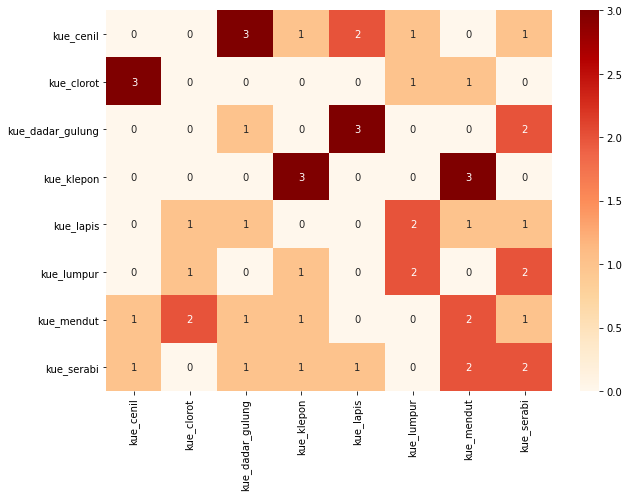

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data,  BATCH_SIZE // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[2 2 1 0 1 1 1 0]
 [0 0 1 2 0 0 1 1]
 [0 0 0 0 1 2 1 2]
 [1 0 1 1 1 0 1 1]
 [1 1 1 1 1 0 0 1]
 [0 0 1 1 0 1 1 2]
 [1 1 0 2 0 0 3 1]
 [0 0 2 0 2 2 1 1]]


<AxesSubplot:>

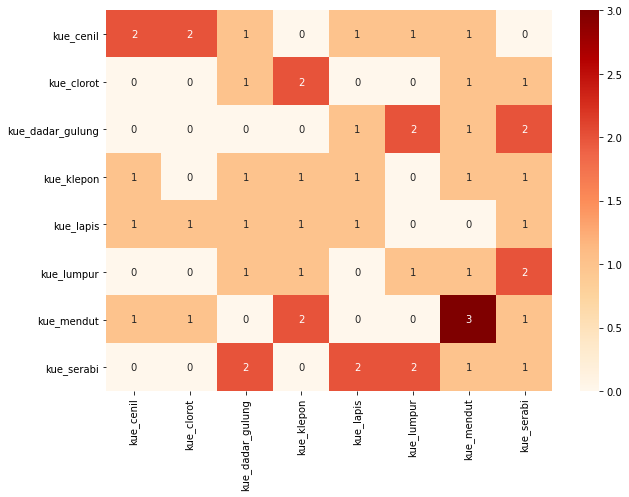

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data,  BATCH_SIZE // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

In [56]:
saved_model_dir = 'model_final'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_final\assets


ValueError: num must be 1 <= num <= 36, not 37

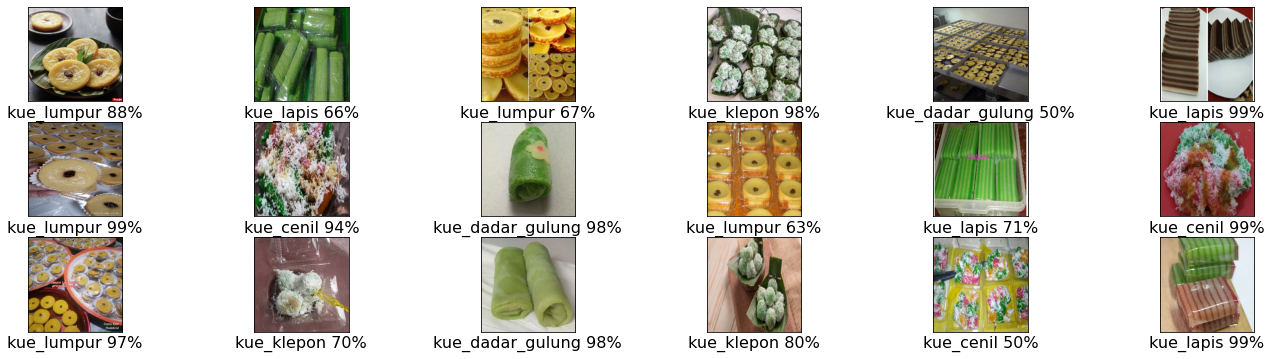

In [137]:
num_rows = 3
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)


  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = model.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()
